In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep, splev

- wrapper for `libspline.so`
    - run `make` before use
    - restart python kernel in case of `ctypes: undefined symbol ...` error

In [3]:
from collections.abc import Iterable
from ctypes import *

LIBSPLINE = './libspline/libspline.so'

T = c_double

class Spline:
    lib = cdll.LoadLibrary(LIBSPLINE)
    lib.spline.restype = c_void_p
    lib.spline.argtypes = [POINTER(T), POINTER(T), c_int, c_int, T, c_int, T, T]
    lib.delete_spline.restype = None
    lib.delete_spline.argtypes = [c_void_p]
    lib.eval.restype = T
    lib.eval.argtypes = [c_void_p, T]   
    lib.eval_vec.restype = c_void_p
    lib.eval_vec.argtypes = [c_void_p, POINTER(T), POINTER(T), c_int]
    lib.deriv.restype = T
    lib.deriv.argtypes = [c_void_p, T]
    lib.deriv2.restype = T
    lib.deriv2.argtypes = [c_void_p, T]
    lib.deriv3.restype = T
    lib.deriv3.argtypes = [c_void_p, T]
    lib.integrate.restype = T
    lib.integrate.argtypes = [c_void_p, T, T]

    def __init__(self, x, y, bc=((2, 0.0), (2, 0.0)), tol=1e-8):
        assert len(x) == len(y), "length mismatch"
        n = len(x)
        xarr = (T * n)(*x)
        yarr = (T * n)(*y)

        (lbc, lbc_val), (rbc, rbc_val) = bc
        self.spline = Spline.lib.spline(xarr, yarr, n, lbc, lbc_val, rbc, rbc_val, tol)

    def __del__(self):
        Spline.lib.delete_spline(self.spline)

    def _eval(self, x):
        return Spline.lib.eval(self.spline, x)

    def deriv(self, x):
        return Spline.lib.deriv(self.spline, x)
    
    def deriv2(self, x):
        return Spline.lib.deriv2(self.spline, x)
    
    def deriv3(self, x):
        return Spline.lib.deriv3(self.spline, x)

    def integrate(self, x1, x2):
        return Spline.lib.integrate(self.spline, x1, x2)

    def __call__(self, x):
        if not isinstance(x, Iterable):
            return self._eval(x)

        n = len(x)
        resarr = (T * n)()
        Spline.lib.eval_vec(self.spline, (T * n)(*x), resarr, n)
        return np.array(resarr)

- usage example

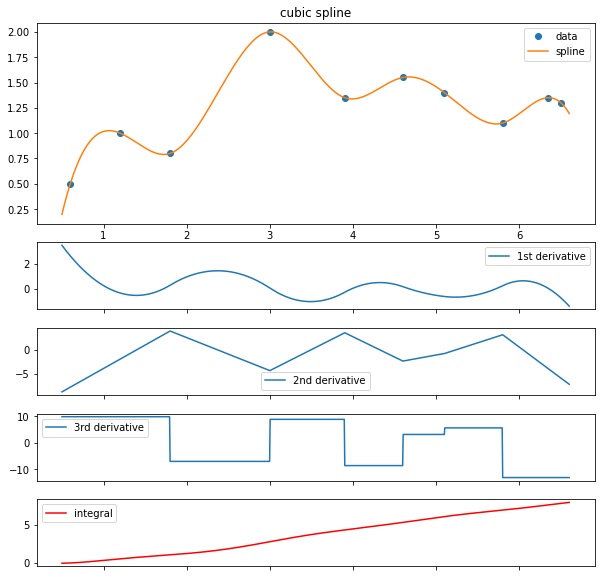

In [4]:
x = [0.6, 1.2, 1.8, 3.0,  3.9,  4.6, 5.1, 5.8, 6.35, 6.5]
y = [0.5, 1.0, 0.8, 2.0, 1.35, 1.55, 1.4, 1.1, 1.35, 1.3]

spl = Spline(x, y, bc=((3, 0.0),(3, 0.0)))   # notaknot
xi = np.linspace(0.5,6.6,1000)

yi = spl(xi)

fig, ax = plt.subplots(5, 1, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]})
ax[0].plot(x, y, 'o', label="data")
ax[0].plot(xi, yi, '-', label="spline")
ax[0].set_title('cubic spline')
ax[0].legend()
ax[1].plot(xi, [spl.deriv(i) for i in xi], '-', label='1st derivative')
ax[1].legend();ax[1].set_xticklabels([])
ax[2].plot(xi, [spl.deriv2(i) for i in xi], '-', label='2nd derivative')
ax[2].legend();ax[2].set_xticklabels([])
ax[3].plot(xi, [spl.deriv3(i) for i in xi], '-', label='3rd derivative')
ax[3].legend();ax[3].set_xticklabels([])
ax[4].plot(xi, [spl.integrate(x[0], i) for i in xi], '-', color='red', label='integral')
ax[4].legend();ax[4].set_xticklabels([]);

**Test data**

- random `n1` points from (0,1) to build spline
- random `n2` points from (-0.5,1.5) to evaluate spline

In [5]:
np.random.seed(42)

n1, n2 = 50, 1000
x = np.random.rand(n1)
x.sort()
x_lin = np.linspace(0,1,n1)         # for case of adjusted factorization

y = np.random.rand(n1)

xi = np.random.rand(n2) * 2 - 0.5   # including extrapolation

**Correctness/accuracy**

In [6]:
clamped_spline = Spline(x, y, bc=((1, 0.0),(1, 0.0)))
clamped_scipy = make_interp_spline(x, y, bc_type=([(1, 0.0)], [(1, 0.0)]))
ycc = clamped_spline(xi)
ylc = clamped_scipy(xi)

natural_spline = Spline(x, y, bc=((2, 0.0),(2, 0.0)))
natural_scipy = make_interp_spline(x, y, bc_type=([(2, 0.0)], [(2, 0.0)]))
ycn = clamped_spline(xi)
yln = clamped_scipy(xi)

notaknot_spline = Spline(x, y, bc=((3, 0.0),(3, 0.0)))
notaknot_scipy = make_interp_spline(x, y, bc_type="not-a-knot")
yck = notaknot_spline(xi)
ylk = notaknot_scipy(xi)

notaknot_spline_lin = Spline(x_lin, y, bc=((3, 0.0),(3, 0.0)))
notaknot_scipy_lin = make_interp_spline(x_lin, y, bc_type="not-a-knot")
yck_lin = notaknot_spline_lin(xi)
ylk_lin = notaknot_scipy_lin(xi)

np.allclose(ycc, ylc), np.allclose(ycn, ylc),  np.allclose(yck, ylk), np.allclose(yck_lin, ylk_lin)

(True, True, True, True)

In [7]:
((ycc - ylc)**2).mean(), ((ycn - ylc)**2).mean(), ((yck - ylk)**2).mean(), ((yck_lin - ylk_lin)**2).mean()

(6.086533721142102e-23,
 6.086533721142102e-23,
 1.1874426422071394e-23,
 6.424743445939142e-25)

**Bechmark**
- with not-a-knot boundary condition

**Accuracy**

In [8]:
sf = splrep(x, y)
sc = Spline(x, y, bc=((3, 0.0),(3, 0.0)))
sl = make_interp_spline(x, y)

yf = splev(xi, sf)
yc = sc(xi)
yl = sl(xi)

((yf - yc)**2).mean(), ((yf - yl)**2).mean(), ((yc - yl)**2).mean()

(3.7701677926132137e-23, 8.166743465068402e-24, 1.1874426422071394e-23)

- all close

In [9]:
np.allclose(yf, yl), np.allclose(yf, yc), np.allclose(yc, yl)

(True, True, True)

**Build spline**

In [10]:
%%timeit
splrep(x, y)

19 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%%timeit
Spline(x, y, bc=((3, 0.0),(3, 0.0)))

25.8 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%%timeit
make_interp_spline(x, y)

212 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Inference**

In [13]:
%%timeit
splev(xi, sf)

83.8 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%%timeit
sl(xi)

88.3 µs ± 320 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%%timeit
sc(xi)

197 µs ± 2.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Total**

In [16]:
%%timeit
sf = splrep(x, y)
splev(xi, sf)

110 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
%%timeit
sc = Spline(x, y, bc=((3, 0.0),(3, 0.0)))
sc(xi)

231 µs ± 6.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
%%timeit
sl = make_interp_spline(x, y)
sl(xi)

355 µs ± 5.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
